# $\fbox{2-5}$ バイアスと修正 ~ 引受査定・ 90 日免責・初回イベント発生率

### 逆選択と選択

### 引受査定の導入

### 準備 & 作成したデータの読み込み

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc

import mylibs.mylib1 as mylib1  # 本書 1 章の関数群を含む自作ライブラリ
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 10

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
df_info = pd.read_csv('./pseudo_medical/records/excl_bp/info.csv')
df_commons = pd.read_csv('./pseudo_medical/records/excl_bp/commons.csv')
df_diseases = pd.read_csv('./pseudo_medical/records/excl_bp/diseases.csv')
df_treatments = pd.read_csv('./pseudo_medical/records/excl_bp/treatments.csv')

### ALB テーブル, エクスポージャテーブルを作成

In [3]:
# 分析開始時点 (2010年1月)
start_study_t = 2010
# 分析終了時点 (2019年12月)
end_study_t = 2019.999

npa_obs_ym = mylib1.create_npa_obs_ym(start_study_t, end_study_t)
df_info = mylib1.convert_ym_to_t_in_info(df_info)
df_alb_table = mylib1.create_alb_table_from_info(npa_obs_ym, df_info)
df_exposure_table = mylib1.create_exposure_table_from_alb_table(
    npa_obs_ym, df_alb_table)

### 入院イベントテーブルを作成

In [4]:
# 入院レコードのみに限定
df_hosps = df_commons[df_commons['receipt_type'] == 'inpatient']
df_admissions = df_hosps.groupby(['iid', 'admission_ym']).first().reset_index()

df_admissions

,iid,admission_ym,rid,ym,receipt_type,days
0,i000003,2010/11,r00000375,2010/11,inpatient,2
1,i000006,2013/07,r00000481,2013/07,inpatient,11
2,i000012,2010/08,r00000680,2010/08,inpatient,7
3,i000012,2011/06,r00000692,2011/06,inpatient,4
...,...,...,...,...,...,...
1460,i008251,2011/01,r00432915,2011/01,inpatient,15
1461,i008251,2011/07,r00432921,2011/07,inpatient,4
1462,i008254,2012/04,r00432999,2012/04,inpatient,15
1463,i008255,2013/02,r00433066,2013/02,inpatient,1


In [5]:
df_event_table = df_alb_table.copy()
df_event_table.loc[:, npa_obs_ym] = 0
for ym in npa_obs_ym:
    is_ym = (df_admissions['admission_ym'] == ym)
    iid_in_ym = df_admissions.loc[is_ym, 'iid'].values
    in_iid_in_ym = df_event_table['iid'].isin(iid_in_ym)
    df_event_table.loc[in_iid_in_ym, ym] = 1


df_event_table

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,...,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,...,0,0,0,0,0
3,i000003,M,2,1989/03,2010/01,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4811,i008259,M,1,2010/01,2010/01,...,0,0,0,0,0
4812,i008260,M,1,1987/02,2019/06,...,0,0,0,0,0
4813,i008263,M,1,1980/08,2010/01,...,0,0,0,0,0
4814,i008264,M,2,1952/06,2010/01,...,0,0,0,0,0


### UW (アンダーライティング) の導入

In [6]:
df_uw_table = df_exposure_table.copy()

# エクスポージャの累積和が 12 以下のとき 1 とする。
# ただし累積和が 0 でも 1 となってしまう。
df_uw_table.loc[:, npa_obs_ym] \
    = (df_uw_table.loc[:, npa_obs_ym].cumsum(axis=1) <= 12) * 1

# そのため、元のエクスポージャが 0 のときは 1 でなく 0 にする。
df_uw_table.loc[:, npa_obs_ym] \
    = df_uw_table.loc[:, npa_obs_ym] * df_uw_table.loc[:, npa_obs_ym]

# UW 期間(12ヶ月) の入院発生件数が 0 → 引受可能
is_accepted = ((df_uw_table.loc[:, npa_obs_ym] *
                df_event_table.loc[:, npa_obs_ym]
                ).sum(axis=1) == 0)
df_event_table = df_event_table[is_accepted]

# エクスポージャから UW 期間を除外する。
df_exposure_table.loc[:, npa_obs_ym] \
    = df_exposure_table.loc[:, npa_obs_ym] - df_uw_table.loc[:, npa_obs_ym]
is_positive = (df_exposure_table.loc[:, npa_obs_ym] > 0)
df_exposure_table.loc[:, npa_obs_ym] = df_exposure_table.loc[:, npa_obs_ym] * \
    is_positive
df_exposure_table = df_exposure_table[is_accepted]
df_alb_table = df_alb_table[is_accepted]

### 男女・ALB ごとにエクスポージャとイベント件数を集計

In [7]:
df_summary = mylib1.count_exposure_and_event(npa_obs_ym,
                                             df_alb_table,
                                             df_exposure_table,
                                             df_event_table)

df_summary['alb_mid'] = df_summary.alb // 5 * 5 + 2

df_summary_5x = df_summary.groupby(['sex', 'alb_mid'])[
    'exposure', 'event'].sum()
df_summary_5x = mylib1.estimate_rate(df_summary_5x, e=0.05)
df_summary_5x = df_summary_5x.reset_index()

df_summary_5x

,sex,alb_mid,exposure,event,obs_rate,LCL,UCL
0,F,2,4212,18,0.004274,0.002705,0.006745
1,F,7,7589,7,0.000922,0.000447,0.001903
2,F,12,7134,0,0.000000,0.000000,0.000538
3,F,17,7444,5,0.000672,0.000287,0.001572
...,...,...,...,...,...,...,...
36,M,82,0,0,NaN,NaN,NaN
37,M,87,0,0,NaN,NaN,NaN
38,M,92,0,0,NaN,NaN,NaN
39,M,97,0,0,NaN,NaN,NaN


### 真の月次がん入院発生率の作成

In [8]:
df_true_hosp_rate = pd.read_csv('./public_stats/processed/ps_admission.csv')


def get_true_admission_rate(df_true_hosp_rate, sex, alb):
    is_sex = (df_true_hosp_rate.sex == sex)
    more_alb_min = (df_true_hosp_rate.alb_min <= alb)
    less_alb_max = (alb <= df_true_hosp_rate.alb_max)
    ix = is_sex & more_alb_min & less_alb_max
    cols = df_true_hosp_rate.columns[3:]
    return df_true_hosp_rate.loc[ix, cols].values.sum()


get_true_admission_rate(df_true_hosp_rate, 'M', 50)

0.00636198875

<IPython.core.display.Javascript object>


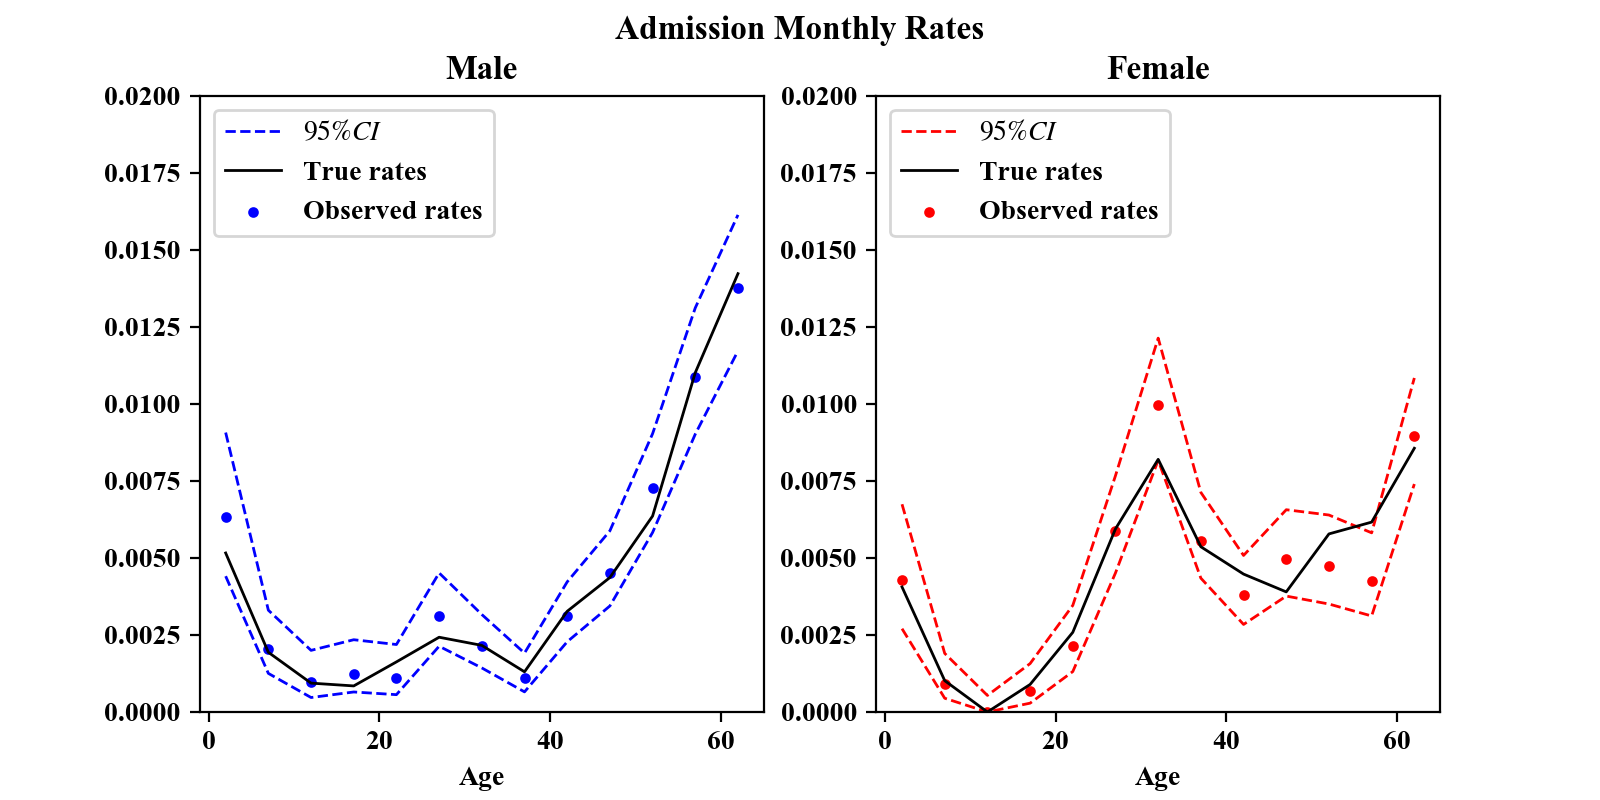

Text(0.5, 0.98, 'Admission Monthly Rates')

In [9]:
df_summary_5x['true_rate'] = 0
for i in df_summary_5x.index:
    (sex, alb) = df_summary_5x.loc[i, ['sex', 'alb_mid']]
    df_summary_5x.loc[i, 'true_rate'] = get_true_admission_rate(
        df_true_hosp_rate, sex, alb)

df = df_summary_5x.loc[(df_summary_5x.alb_mid < 65)]
df_M = df.loc[df.sex == 'M']
df_F = df.loc[df.sex == 'F']


def plot_rates(ax, df_sex, color):
    ax.scatter(df_sex.alb_mid, df_sex.obs_rate,
               c=color, s=8, label='Observed rates')
    ax.plot(df_sex.alb_mid, df_sex.LCL, c=color,
            ls='--', lw=1, label=r'$95\% CI$')
    ax.plot(df_sex.alb_mid, df_sex.UCL, c=color, ls='--', lw=1)
    ax.plot(df_sex.alb_mid, df_sex.true_rate,
            c='k', ls='-', lw=1, label='True rates')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 0.02)


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot_rates(ax1, df_M, 'b')
ax1.set_title('Male')
ax1.set_xlabel('Age')

ax2 = fig.add_subplot(122)
plot_rates(ax2, df_F, 'r')
ax2.set_title('Female')
ax2.set_xlabel('Age')

fig.suptitle('Admission Monthly Rates')

### がん $90$ 日免責

### エクスポージャと保険料徴収期間